# Getting started with concise

## Become familiar with Keras

In order to successfully use concise, please make sure you are familiar with keras. I strongly advise everyone to read the excellent [keras documentation](http://keras.io) first.

Being a keras extension, concise namely tightly follows the keras API.

## DeepBind model in concise

DeepBind model is extremely straightforward.

It's main architecture:

- conv
- maxpool
- dense
- dense

can be expressed in concise in the following way. Note that I prefer to use the functional API of keras.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import concise.layers as cl
import keras.layers as kl
from concise.preprocessing import encodeDNA
from keras.models import Model, load_model

Using TensorFlow backend.


In [ ]:
# get the data
seq_list = read_fasta - TODO
seq_list[:5]
y = ...as_matrix()

# encode sequences as one-hot encoded arrays
x_seq = encodeDNA(seq_list)

In [27]:
# specify the model
in_dna = cl.InputDNA(seq_length=100, name="seq")
x = cl.ConvDNA(filters=15, kernel_size=12, activation="relu")(in_dna)
x = kl.MaxPool1D(pool_size=4)(x) # TODO - check
x = kl.Flatten()(x)
x = kl.Dense(100, activation="relu")(x)
out = kl.Dense(1, activation="sigmoid")(x)
m = Model(in_dna, out)
m.compile("adam", loss="binary_crossentropy", metrics=["acc"])

# train the model
m.fit(x_seq, y, epochs=3)

# save the model
m.save("/tmp/model.h5")

# load the model
m2 = load_model(m)

# visualize the filters
m2.layers[1].plot_weights()

m2.layers[1].plot_weights("pwm_info")

NameError: name 'x_seq' is not defined

## Initializing filters on known motifs

In the scenario where data is scarse, it is often useful to initialize the filters to some known position weights matrices (PWM's). That way, the model already starts with a parameter configuration much closes to the 'right' solution.

Concise provides access to (TODO how many) transcription factor PWM's from ENCODE and rna-binding proteins PWM's from ATtrACT (1000 - TODO - show numbers).

### Find the motif of interest

In [3]:
from concise.data import attract

dfa = attract.get_metadata()
dfa

,PWM_id,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Score
0,519,3IVK,3IVK,no,Mus_musculus,GAAACA,6,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
1,574,3IVK,3IVK,no,Mus_musculus,UGGG,4,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,1.000000**
2,464,4KZD,4KZD,no,Mus_musculus,GAAAC,5,X-RAY DIFFRACTION,PDB,24952597,X-RAY DIFFRACTION,NaN,1.000000**
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4879,1396,HNRNPAB,ENSG00000197451,no,Homo_sapiens,AUAGCA,6,In vitro splicing assays,AEDB,12426391,other,RRM,1.000000**
4880,1397,HNRNPA1,ENSG00000135486,no,Homo_sapiens,UAGG,4,Immunoprecipitation;U...,AEDB,15506926,UV cross-linking,RRM,1.000000**
4881,1398,PTBP1,ENSG00000011304,no,Homo_sapiens,UUCUUC,6,In vivo splicing assa...,AEDB,14966131,UV cross-linking,RRM,1.000000**


Let's choose a PWMs of the following transcription factors:

In [4]:
from concise.data import encode

dfe = encode.get_metadata()
dfe

,motif_name,consensus
0,AFP_1,ATTAACTACAC
1,AHR::ARNT::HIF1A_1,TGCGTGCGG
2,AHR::ARNT_1,TAAGGGTTGCGTGCCC
...,...,...
2064,ZSCAN4_3,TGCACACACTGAAAA
2065,fake_AACGSSAA,AACGCCAA
2066,fake_AAGCSSAA,AAGCCCAA


In [5]:
dfe[dfe.motif_name.str.match("GATA")]

,motif_name,consensus
558,GATA_disc1,GCAGATAAGG
559,GATA_disc2,TGACTCACAC
560,GATA_disc3,TCATTTCCTGC
...,...,...
583,GATA_known7,AGATAAGGCCT
584,GATA_known8,GCAGATAACA
585,GATA_known9,AAAGATAAGC


In [6]:
dfe[dfe.motif_name.str.match("CTCF")]

,motif_name,consensus
195,CTCFL_disc1,GCGCCCCCTG
196,CTCF_disc1,TGCAATAGTGCCATCTAGTGGT
197,CTCF_disc10,ACCTGCAGG
...,...,...
205,CTCF_disc9,GCCCACTAGAGGGCAC
206,CTCF_known1,TGGCCACCAGGGGGCGCTA
207,CTCF_known2,AGCGCCACCTAGTGGTA


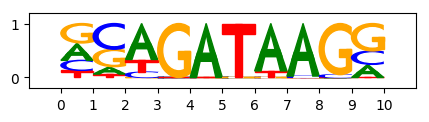

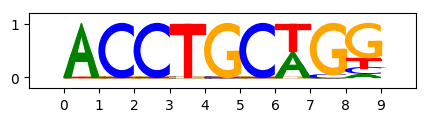

In [7]:
from concise.utils.pwm import PWM
pwm_list = encode.get_pwm_list(["GATA_disc1", "CTCF_disc10"])
for pwm in pwm_list:
    pwm.plotPWM(figsize=(5,1))

### Initialize the model with the motif

In [8]:
import concise.initializers as ci
in_dna = cl.InputDNA(seq_length=100, name="seq")
x = cl.ConvDNA(filters=15, 
               kernel_size=12, 
               kernel_initializer=ci.PSSMKernelInitializer(pwm_list),
               bias_initializer=ci.PSSMBiasInitializer(pwm_list),
               activation="relu")(in_dna)
x = kl.MaxPool1D(pool_size=4)(x)
x = kl.Flatten()(x)
x = kl.Dense(100, activation="relu")(x)
out = kl.Dense(1, activation="sigmoid")(x)
m = Model(in_dna, out)
m.compile("adam", loss="binary_crossentropy", metrics=["acc"])

This will set the filters of the first convolutional layer to the values of the position-specific scoring matrix (PSSM):

$$ pssm_{ij} = log \frac{pwm_{ij}}{b_j} \;,$$

where $b_j$ is the background probability of observing base $j$.

We add gaussian noise to each individual filter. Let's visualize the filters:

filter index: 1


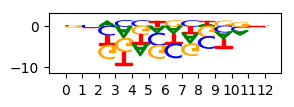

filter index: 2


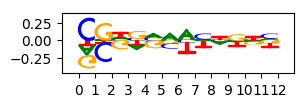

filter index: 3


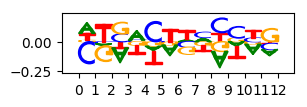

filter index: 4


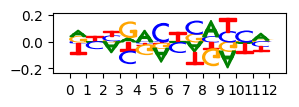

In [13]:
m.layers[1].plot_weights([1,2,3,4],figsize=(3,0.8))